EDA
df.head():
  Species  CulmenLength  CulmenDepth  FlipperLength OriginLocation  BodyMass
0  Adelie          39.1         18.7          181.0      Torgersen    3750.0
1  Adelie          39.5         17.4          186.0      Torgersen    3800.0
2  Adelie          40.3         18.0          195.0      Torgersen    3250.0
3  Adelie           NaN          NaN            NaN      Torgersen       NaN
4  Adelie          36.7         19.3          193.0      Torgersen    3450.0

df.tail():
    Species  CulmenLength  CulmenDepth  FlipperLength OriginLocation  BodyMass
145  Gentoo           NaN          NaN            NaN         Biscoe       NaN
146  Gentoo          46.8         14.3          215.0         Biscoe    4850.0
147  Gentoo          50.4         15.7          222.0         Biscoe    5750.0
148  Gentoo          45.2         14.8          212.0         Biscoe    5200.0
149  Gentoo          49.9         16.1          213.0         Biscoe    5400.0

df.shape: (150, 6)

df.columns: ['Sp

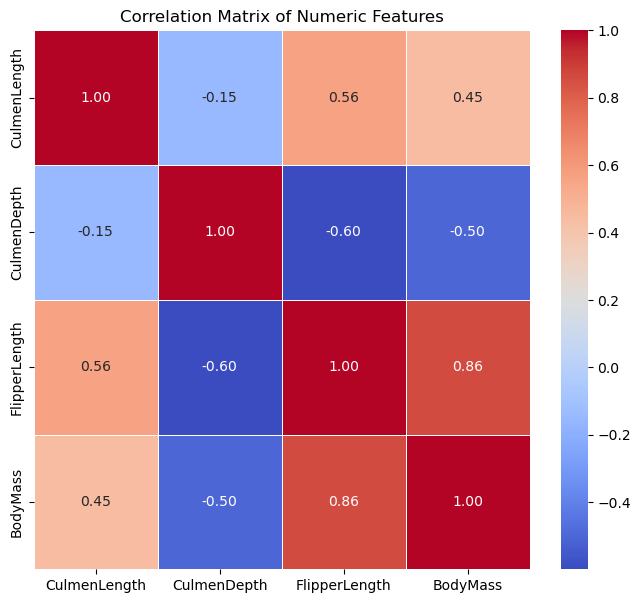

<Figure size 800x600 with 0 Axes>

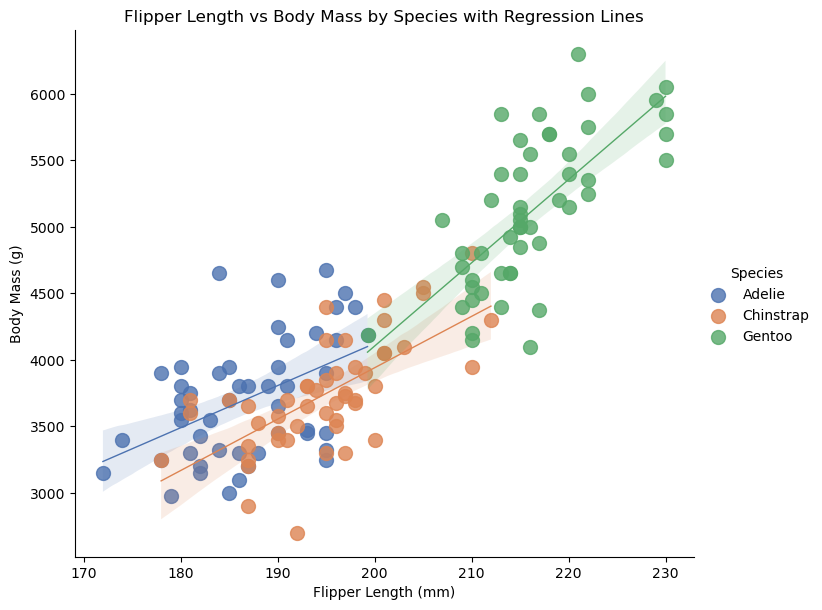

<Figure size 800x600 with 0 Axes>

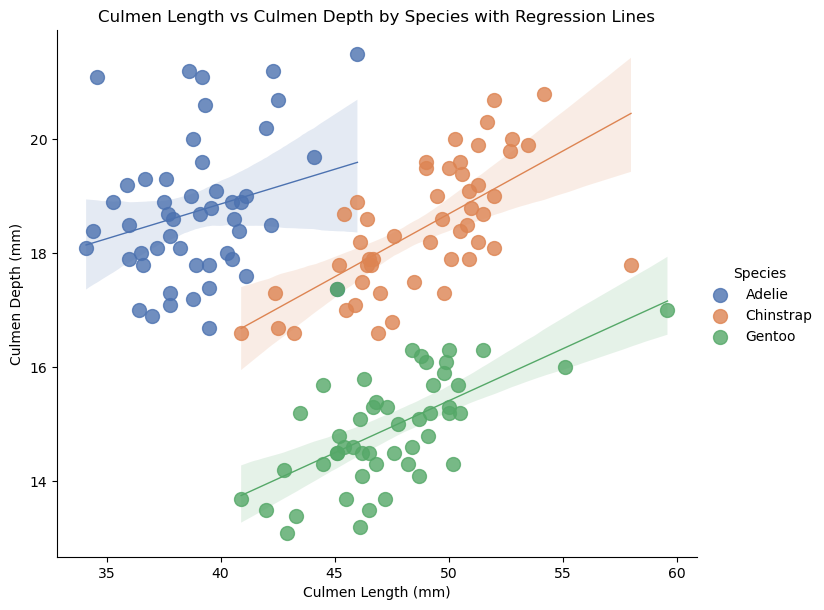

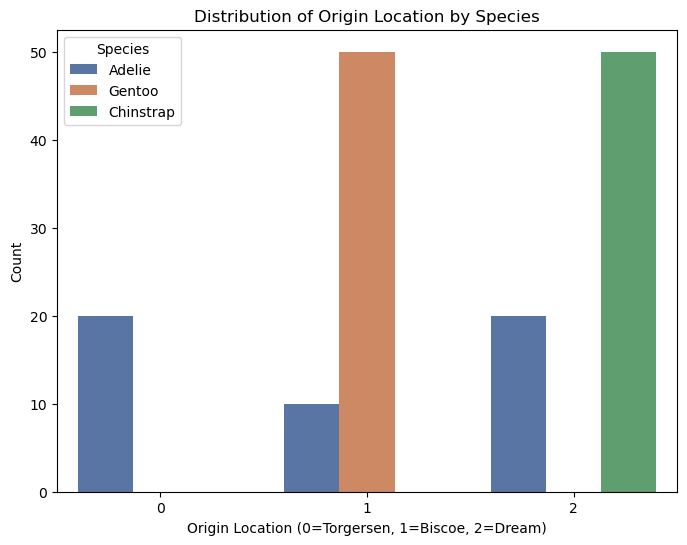

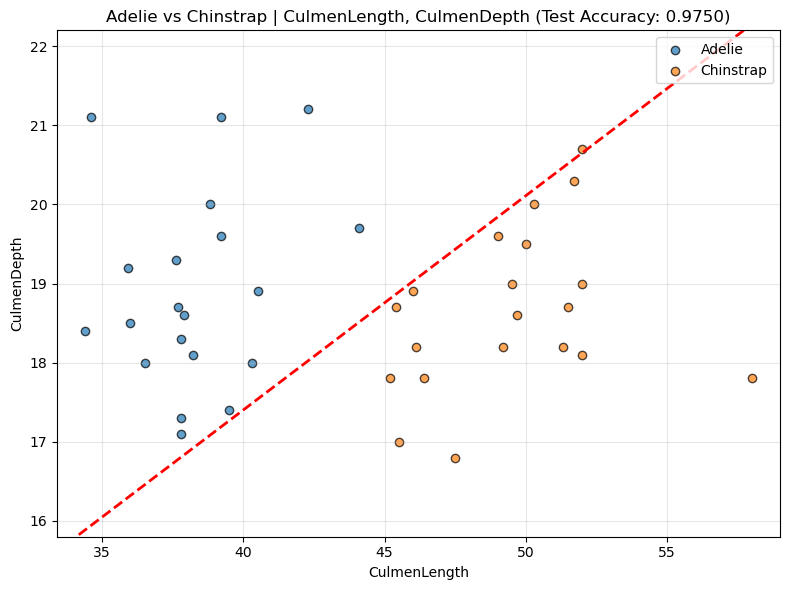

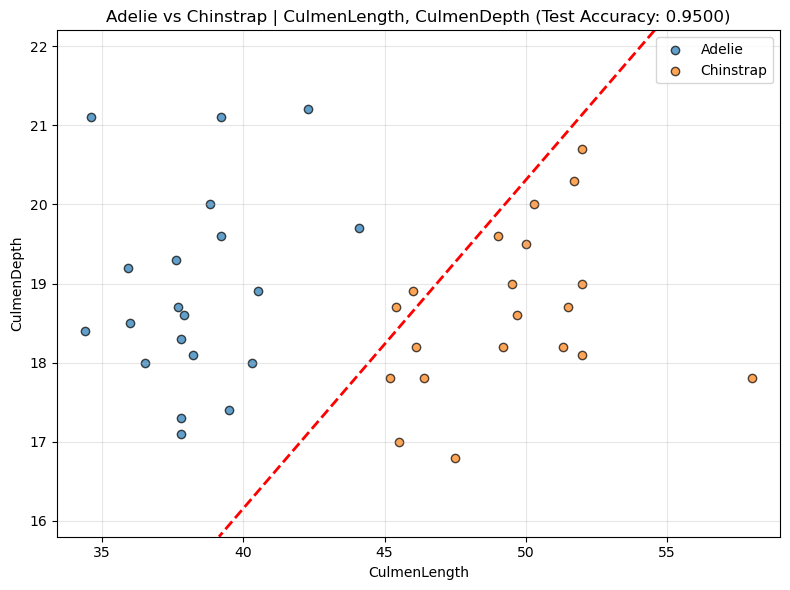

In [19]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tkinter as tk
from tkinter import ttk, messagebox
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)
#read CSV
df = pd.read_csv('penguins.csv')

print("EDA")
print("df.head():")
print(df.head())
print("\ndf.tail():")
print(df.tail())
print("\ndf.shape:", df.shape)
print("\ndf.columns:", df.columns.tolist())
print("\ndf.dtypes:\n", df.dtypes)
print("\ndf.info():")
df.info()
print("\ndf.describe():")
print(df.describe())

#Check Duplicates
print("\ndf.duplicated().sum():", df.duplicated().sum())
# NO Duplicated

# Outliers
print("\n..........................check outliers...............................")
outlier_counts = {}
for col in df.select_dtypes(include=np.number).columns:
    q1 = np.percentile(df[col].dropna(), 25)
    q3 = np.percentile(df[col].dropna(), 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    lower_outliers = df[df[col].notnull() & (df[col] < lower_bound)]
    upper_outliers = df[df[col].notnull() & (df[col] > upper_bound)] 
    outliers = len(lower_outliers) + len(upper_outliers)
    outlier_counts[col] = outliers

for col, count in outlier_counts.items():
    print(f"the number of outliers in '{col}': {count}")

print("df['Species'].value_counts():\n", df['Species'].value_counts())
print("\ndf['OriginLocation'].value_counts():\n", df['OriginLocation'].value_counts())



print("\n........................check nulls.......................................")
print("\ndf.isnull().sum():\n", df.isnull().sum())

#encoding for OriginLocation
location = {'Torgersen': 0, 'Biscoe': 1, 'Dream': 2}
df['OriginLocation'] = df['OriginLocation'].map(location)

#impute Missing Values by mean and mode
numeric_cols = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())
mode_loc = df['OriginLocation'].mode()[0]
df['OriginLocation'] = df['OriginLocation'].fillna(mode_loc)

print("\nafter dealing with nulls:\n", df.isnull().sum())

ALL_FEATURES = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass', 'OriginLocation']

#visualization 
#heatmap for corr
plt.figure(figsize=(8, 7))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show() 

#Flipper Length and body mass(scatter)
plt.figure(figsize=(8, 6))
sns.lmplot(data=df, x='FlipperLength', y='BodyMass', hue='Species', palette='deep', height=6, aspect=1.2, scatter_kws={'s': 100}, line_kws={'lw': 1})
plt.title('Flipper Length vs Body Mass by Species with Regression Lines')
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Body Mass (g)')
plt.show() 


#Culmen Length and culmen Depth 
plt.figure(figsize=(8, 6))
sns.lmplot(data=df, x='CulmenLength', y='CulmenDepth', hue='Species', palette='deep', height=6, aspect=1.2, scatter_kws={'s': 100}, line_kws={'lw': 1})
plt.title('Culmen Length vs Culmen Depth by Species with Regression Lines')
plt.xlabel('Culmen Length (mm)')
plt.ylabel('Culmen Depth (mm)')
plt.show() 

#dist of OriginLocation
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='OriginLocation', hue='Species', palette='deep')
plt.title('Distribution of Origin Location by Species')
plt.xlabel('Origin Location (0=Torgersen, 1=Biscoe, 2=Dream)')
plt.ylabel('Count')
plt.legend(title='Species')
plt.show()

#Random choose 30 samples from each class for train and 20 for test
def prepare_data(df, class1, class2, feat1, feat2, use_bias=True, random_seed=42):
    """Prepares and normalizes the training and test data."""
    np.random.seed(random_seed)

    data = df[df["Species"].isin([class1, class2])].copy()
    data["label"] = data["Species"].map({class1: -1, class2: 1})

    idx1 = data[data["Species"] == class1].index.values
    idx2 = data[data["Species"] == class2].index.values
    train_idx = np.concatenate([
        np.random.choice(idx1, 30, replace=False),
        np.random.choice(idx2, 30, replace=False)
    ])

    test_idx = data.index.difference(train_idx)

    X_train_raw = data.loc[train_idx, [feat1, feat2]].values
    X_test_raw = data.loc[test_idx, [feat1, feat2]].values
    y_train = data.loc[train_idx, "label"].values
    y_test = data.loc[test_idx, "label"].values

    mean = X_train_raw.mean(axis=0)
    std = X_train_raw.std(axis=0) + 1e-8
    X_train = (X_train_raw - mean) / std
    X_test = (X_test_raw - mean) / std

    if use_bias:
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]
        X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    return X_train, y_train, X_test, y_test, X_train_raw, X_test_raw, mean, std




#Conf Matrix from scratch
def manual_confusion_matrix(y_true, y_pred):
    y_pred = np.where(y_pred >= 0, 1, -1)

    tn = np.sum((y_true == -1) & (y_pred == -1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == -1))
    tp = np.sum((y_true == 1) & (y_pred == 1))

    if len(y_true) == 0:
        return [[0, 0], [0, 0]], 0.0

    acc = (tp + tn) / len(y_true)
    return [[tn, fp], [fn, tp]], acc

#plots the data and the decision boundary
def plot_and_show(X_raw, y, weights, feat1, feat2, class1, class2, metric_value, metric_name, mean, std, use_bias=True):
    plt.figure(figsize=(8, 6))

    plt.scatter(X_raw[y == -1, 0], X_raw[y == -1, 1], label=class1, alpha=0.7, edgecolors='k', color='tab:blue')
    plt.scatter(X_raw[y == 1, 0], X_raw[y == 1, 1], label=class2, alpha=0.7, edgecolors='k', color='tab:orange')

    x1_min, x1_max = X_raw[:, 0].min() - 1, X_raw[:, 0].max() + 1
    x2_min, x2_max = X_raw[:, 1].min() - 1, X_raw[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))

    grid_raw = np.c_[xx1.ravel(), xx2.ravel()]
    grid_norm = (grid_raw - mean) / std

    if use_bias:
        grid_input = np.c_[np.ones(grid_norm.shape[0]), grid_norm]
    else:
        grid_input = grid_norm

    if weights.size == grid_input.shape[1]:
        zz = (grid_input @ weights).reshape(xx1.shape)
        plt.contour(xx1, xx2, zz, levels=[0], colors='red', linestyles='--', linewidths=2)

    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"{class1} vs {class2} | {feat1}, {feat2} ({metric_name}: {metric_value:.4f})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()





# Perceptron Model

def train_perceptron(X, y, learning_rate=0.01, epochs=100, random_seed=42):
    np.random.seed(random_seed)
    n_features = X.shape[1]
    w = np.random.rand(n_features) * 0.01
    errors = []

    for epoch in range(epochs):
        n_misclassified = 0
        indices = np.random.permutation(X.shape[0])
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for xi, target in zip(X_shuffled, y_shuffled):
            net_input = np.dot(xi, w)
            prediction = np.where(net_input >= 0.0, 1, -1)
            error = target - prediction

            if error != 0:
                w += learning_rate * error * xi
                n_misclassified += 1

        errors.append(n_misclassified)
        if n_misclassified == 0:
            break

    return w, errors


def run_perceptron_experiment(class1, class2, feat1, feat2, eta=0.1, epochs=200, random_seed=42, use_bias=True):

    X_train, y_train, X_test, y_test, X_train_raw, X_test_raw, mean, std = prepare_data(
        df, class1, class2, feat1, feat2, use_bias=use_bias, random_seed=random_seed
    )

    weights, errors = train_perceptron(X_train, y_train, learning_rate=eta, epochs=epochs, random_seed=random_seed)

    convergence_metric = errors[-1]
    converged_epoch = len(errors) if errors[-1] == 0 else "N/A"

    y_pred_test = np.where(X_test @ weights >= 0, 1, -1)
    cm_test, acc_test = manual_confusion_matrix(y_test, y_pred_test)

    plot_and_show(X_test_raw, y_test, weights, feat1, feat2, class1, class2, acc_test, "Test Accuracy", mean, std,
                  use_bias)

    return acc_test, cm_test, converged_epoch, convergence_metric


#Adaline Model
#trains the Adaline model using Stochastic Gradient Descent (SGD)
def adaline_train(X, y, learning_rate=0.01, epochs=100, mse_threshold=1e-6, random_seed=42):
    np.random.seed(random_seed)
    n_samples, n_features = X.shape
    weights = np.random.rand(n_features) * 0.01
    mse_history = []

    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(n_samples):
            xi = X_shuffled[i]
            ti = y_shuffled[i]
            yi = np.dot(weights, xi)
            error = ti - yi
            weights += learning_rate * error * xi

        output = X @ weights
        mse = np.mean((y - output) ** 2)
        mse_history.append(mse)

        if mse < mse_threshold:
            break

    return weights, mse_history


def run_adaline_experiment(class1, class2, feat1, feat2, eta=0.1, epochs=200, mse_threshold=1e-6, random_seed=42,
                           use_bias=True):

    X_train, y_train, X_test, y_test, X_train_raw, X_test_raw, mean, std = prepare_data(
        df, class1, class2, feat1, feat2, use_bias=use_bias, random_seed=random_seed
    )

    weights, mse_history = adaline_train(X_train, y_train, learning_rate=eta, epochs=epochs,
                                         mse_threshold=mse_threshold, random_seed=random_seed)

    final_train_mse = mse_history[-1]

    y_pred_test = np.where(X_test @ weights >= 0, 1, -1)
    cm_test, acc_test = manual_confusion_matrix(y_test, y_pred_test)

    test_output = X_test @ weights
    test_mse = np.mean((y_test - test_output) ** 2)

    plot_and_show(X_test_raw, y_test, weights, feat1, feat2, class1, class2, acc_test, "Test Accuracy", mean, std,
                  use_bias)

    return acc_test, cm_test, test_mse, final_train_mse


#GUI Application

class AlgorithmWindow(tk.Toplevel):

    def __init__(self, master, calling_button, algorithm_name):
        super().__init__(master)
        self.calling_button = calling_button
        self.algorithm_name = algorithm_name
        self.title(f"{algorithm_name} Training App")

        self.protocol("WM_DELETE_WINDOW", self.on_close)

        self.geometry("600x650")
        self.configure(bg='#f0f0f0')

        self.species_options = df["Species"].unique().tolist()
        self.feature_options = ALL_FEATURES

        style = ttk.Style(self)
        style.theme_use('clam')
        style.configure('TFrame', background='#f0f0f0')
        style.configure('TLabel', background='#f0f0f0', font=('Arial', 10))
        style.configure('TButton', font=('Arial', 10, 'bold'), padding=10)

        canvas = tk.Canvas(self, borderwidth=0, background='#f0f0f0')
        v_scrollbar = ttk.Scrollbar(self, orient="vertical", command=canvas.yview)
        v_scrollbar.pack(side="right", fill="y")
        canvas.pack(side="left", fill="both", expand=True)
        canvas.configure(yscrollcommand=v_scrollbar.set)

        self.scroll_frame = ttk.Frame(canvas, padding="20 20 20 20")
        canvas.create_window((0, 0), window=self.scroll_frame, anchor="nw",
                             tags="self.scroll_frame")

        self.scroll_frame.bind("<Configure>", lambda e: canvas.configure(
            scrollregion=canvas.bbox("all")
        ))

        def on_mouse_wheel(event):
            if canvas.winfo_containing(event.x_root, event.y_root) in canvas.winfo_children():
                canvas.yview_scroll(int(-1 * (event.delta / 120)), "units")

        self.bind_all("<MouseWheel>", on_mouse_wheel)

        title = ttk.Label(self.scroll_frame, text=f"{algorithm_name} Penguin Classifier", font=('Arial', 16, 'bold'))
        title.grid(row=0, column=0, columnspan=2, pady=(0, 20), sticky="ew")

        row_counter = 1
        ttk.Label(self.scroll_frame, text="1. Select Classes (Two unique species):", font=('Arial', 11, 'bold')).grid(
            row=row_counter, column=0, columnspan=2, pady=(10, 5), sticky="w")
        row_counter += 1

        ttk.Label(self.scroll_frame, text="Class 1:").grid(row=row_counter, column=0, padx=5, pady=5, sticky="w")
        self.class1_var = tk.StringVar(value=self.species_options[0])
        self.class1_combo = ttk.Combobox(self.scroll_frame, textvariable=self.class1_var, values=self.species_options,
                                         state="readonly", width=30)
        self.class1_combo.grid(row=row_counter, column=1, padx=5, pady=5, sticky="e")
        row_counter += 1

        ttk.Label(self.scroll_frame, text="Class 2:").grid(row=row_counter, column=0, padx=5, pady=5, sticky="w")
        self.class2_var = tk.StringVar(value=self.species_options[1])
        self.class2_combo = ttk.Combobox(self.scroll_frame, textvariable=self.class2_var, values=self.species_options,
                                         state="readonly", width=30)
        self.class2_combo.grid(row=row_counter, column=1, padx=5, pady=5, sticky="e")
        row_counter += 1

        ttk.Separator(self.scroll_frame, orient='horizontal').grid(row=row_counter, column=0, columnspan=2, sticky='ew',
                                                                   pady=10)
        row_counter += 1

        ttk.Label(self.scroll_frame, text="2. Select Features (Two unique features):", font=('Arial', 11, 'bold')).grid(
            row=row_counter, column=0, columnspan=2, pady=(10, 5), sticky="w")
        row_counter += 1

        ttk.Label(self.scroll_frame, text="Feature 1:").grid(row=row_counter, column=0, padx=5, pady=5, sticky="w")
        self.feat1_var = tk.StringVar(value=self.feature_options[0])
        self.feat1_combo = ttk.Combobox(self.scroll_frame, textvariable=self.feat1_var, values=self.feature_options,
                                        state="readonly", width=30)
        self.feat1_combo.grid(row=row_counter, column=1, padx=5, pady=5, sticky="e")
        row_counter += 1

        ttk.Label(self.scroll_frame, text="Feature 2:").grid(row=row_counter, column=0, padx=5, pady=5, sticky="w")
        self.feat2_var = tk.StringVar(value=self.feature_options[1])
        self.feat2_combo = ttk.Combobox(self.scroll_frame, textvariable=self.feat2_var, values=self.feature_options,
                                        state="readonly", width=30)
        self.feat2_combo.grid(row=row_counter, column=1, padx=5, pady=5, sticky="e")
        row_counter += 1

        ttk.Separator(self.scroll_frame, orient='horizontal').grid(row=row_counter, column=0, columnspan=2, sticky='ew',
                                                                   pady=10)
        row_counter += 1

        ttk.Label(self.scroll_frame, text="3. Training Parameters:", font=('Arial', 11, 'bold')).grid(row=row_counter,
                                                                                                      column=0,
                                                                                                      columnspan=2,
                                                                                                      pady=(10, 5),
                                                                                                      sticky="w")
        row_counter += 1

        ttk.Label(self.scroll_frame, text="Max Epochs (m):").grid(row=row_counter, column=0, padx=5, pady=5, sticky="w")
        self.epochs_var = tk.StringVar(value="200")
        epochs_entry = ttk.Entry(self.scroll_frame, textvariable=self.epochs_var, width=15)
        epochs_entry.grid(row=row_counter, column=1, padx=5, pady=5, sticky="e")
        row_counter += 1

        ttk.Label(self.scroll_frame, text="Learning Rate (eta):").grid(row=row_counter, column=0, padx=5, pady=5,
                                                                       sticky="w")
        self.lr_var = tk.StringVar(value="0.1")
        lr_entry = ttk.Entry(self.scroll_frame, textvariable=self.lr_var, width=15)
        lr_entry.grid(row=row_counter, column=1, padx=5, pady=5, sticky="e")
        row_counter += 1

        if self.algorithm_name == "Adaline":
            ttk.Label(self.scroll_frame, text="MSE Threshold:").grid(row=row_counter, column=0, padx=5, pady=5,
                                                                     sticky="w")
            self.mse_threshold_var = tk.StringVar(value="1e-6")
            mse_entry = ttk.Entry(self.scroll_frame, textvariable=self.mse_threshold_var, width=15)
            mse_entry.grid(row=row_counter, column=1, padx=5, pady=5, sticky="e")
            row_counter += 1
        else:
            self.mse_threshold_var = tk.StringVar(value="0")

        self.bias_var = tk.BooleanVar(value=True)
        bias_check = ttk.Checkbutton(self.scroll_frame, text="Add Bias Term (w0)", variable=self.bias_var)
        bias_check.grid(row=row_counter, column=0, columnspan=2, pady=5, sticky="w")
        row_counter += 1

        run_button = ttk.Button(self.scroll_frame, text=f"Run {algorithm_name} Analysis", command=self.run_analysis)
        run_button.grid(row=row_counter, column=0, columnspan=2, pady=(20, 10), sticky="ew")
        row_counter += 1

        self.result_label = ttk.Label(self.scroll_frame, text="Select parameters and click 'Run'.", foreground='blue',
                                      wraplength=500, justify=tk.LEFT, anchor='nw')
        self.result_label.grid(row=row_counter, column=0, columnspan=2, pady=(10, 0), sticky="nw")

        self.scroll_frame.grid_columnconfigure(0, weight=1)
        self.scroll_frame.grid_columnconfigure(1, weight=1)

    def on_close(self):
        # Removed try-except from on_close
        self.calling_button.config(state=tk.NORMAL)
        self.destroy()

    def validate_inputs(self):
        # Numeric conversions rely on run_analysis to catch ValueError if they fail
        class1 = self.class1_var.get()
        class2 = self.class2_var.get()
        feat1 = self.feat1_var.get()
        feat2 = self.feat2_var.get()

        if class1 == class2:
            return False, "Please select two DIFFERENT classes (species)."
        if feat1 == feat2:
            return False, "Please select two DIFFERENT features."

        epochs = int(self.epochs_var.get())
        if epochs <= 0:
            return False, "Number of Epochs must be a positive integer."

        learning_rate = float(self.lr_var.get())
        if learning_rate <= 0:
            return False, "Learning Rate must be greater than zero."

        if self.algorithm_name == "Adaline":
            mse_threshold = float(self.mse_threshold_var.get())
            if mse_threshold <= 0:
                return False, "MSE Threshold must be greater than zero."

        return True, "Success"

    def run_analysis(self):
        """Reads input parameters, validates them, and runs the actual training experiment."""
        # Note: All potential conversion errors (e.g., typing 'a' in epoch field)
        # will now cause the application to crash if not handled by validate_inputs.

        is_valid, msg = self.validate_inputs()
        if not is_valid:
            messagebox.showerror("Input Error", msg)
            self.result_label.config(text=f"Error: {msg}", foreground='red')
            return

        self.result_label.config(text=f"Running {self.algorithm_name} analysis...", foreground='orange')
        self.update_idletasks()

        # No main try-except block here
        class1 = self.class1_var.get()
        class2 = self.class2_var.get()
        feat1 = self.feat1_var.get()
        feat2 = self.feat2_var.get()
        epochs = int(self.epochs_var.get())
        learning_rate = float(self.lr_var.get())
        use_bias = self.bias_var.get()
        mse_threshold = float(self.mse_threshold_var.get()) if self.algorithm_name == "Adaline" else 0.0

        if self.algorithm_name == "Perceptron":
            acc_test, cm_test, converged_epoch, final_misclassified = run_perceptron_experiment(
                class1, class2, feat1, feat2,
                eta=learning_rate,
                epochs=epochs,
                use_bias=use_bias
            )
            convergence_info = f"Convergence Epoch: {converged_epoch}\nFinal Misclassified: {final_misclassified}"
            metric_name = "Misclassified"

        elif self.algorithm_name == "Adaline":
            acc_test, cm_test, test_mse, final_train_mse = run_adaline_experiment(
                class1, class2, feat1, feat2,
                eta=learning_rate,
                epochs=epochs,
                mse_threshold=mse_threshold,
                use_bias=use_bias
            )
            convergence_info = f"Final Train MSE: {final_train_mse:.6f}\nTest MSE: {test_mse:.6f}"
            metric_name = "Final Train MSE"
        else:
            messagebox.showerror("Error", "Unknown algorithm selected.")
            return

        message = (f"Analysis Complete! ({self.algorithm_name}: {class1} vs {class2})\n"
                   f"...........Parameters & Performance.........\n"
                   f"Features: {feat1} and {feat2}\n"
                   f"Max Epochs: {epochs}\n"
                   f"Learning Rate (eta): {learning_rate:.4f}\n"
                   f"Bias Used: {'Yes' if use_bias else 'No'}\n"
                   f"{metric_name} Threshold: {mse_threshold if self.algorithm_name == 'Adaline' else 'N/A'}\n"
                   f"\n...............Convergence .........\n"
                   f"{convergence_info}\n"
                   f"\n....... Test Results (20 samples per class) ......... \n"
                   f"Test Accuracy: {acc_test:.2%}\n"
                   f"\nConfusion Matrix (Test Set):\n"
                   f"  TN ({class1} correctly classified): {cm_test[0][0]}\n"
                   f"  FP ({class1} misclassified as {class2}): {cm_test[0][1]}\n"
                   f"  FN ({class2} misclassified as {class1}): {cm_test[1][0]}\n"
                   f"  TP ({class2} correctly classified): {cm_test[1][1]}\n"
                   )

        self.result_label.config(text=message, foreground='green')


# --- Main Menu Window ---

class MainMenu(tk.Tk):

    def __init__(self):
        super().__init__()
        self.title("Neural Network Experiment Selector")
        self.geometry("350x250")
        self.configure(bg='#f0f0f0')

        style = ttk.Style(self)
        style.theme_use('clam')
        style.configure('TFrame', background='#f0f0f0')
        style.configure('TLabel', background='#f0f0f0', font=('Arial', 10))
        style.configure('Algorithm.TButton', font=('Arial', 12, 'bold'), padding=15, foreground='darkblue')

        main_frame = ttk.Frame(self, padding="30 30 30 30")
        main_frame.pack(expand=True, fill='both')

        ttk.Label(main_frame, text="Select an Algorithm to Configure:", font=('Arial', 14, 'bold')).pack(pady=(0, 20))

        self.perceptron_button = ttk.Button(
            main_frame,
            text="Perceptron",
            command=lambda: self.open_algorithm_window("Perceptron"),
            style='Algorithm.TButton'
        )
        self.perceptron_button.pack(fill='x', pady=10)

        self.adaline_button = ttk.Button(
            main_frame,
            text="Adaline",
            command=lambda: self.open_algorithm_window("Adaline"),
            style='Algorithm.TButton'
        )
        self.adaline_button.pack(fill='x', pady=10)

    def open_algorithm_window(self, algorithm_name):
        if algorithm_name == "Perceptron":
            button_to_disable = self.perceptron_button
        elif algorithm_name == "Adaline":
            button_to_disable = self.adaline_button
        else:
            return

        button_to_disable.config(state=tk.DISABLED)
        AlgorithmWindow(self, button_to_disable, algorithm_name)


if __name__ == "__main__":
    plt.ion()

    app = MainMenu()
    app.mainloop()
